In [ ]:
!pip install trimesh vedo numpy matplotlib imageio[ffmpeg] pillow --quiet

In [ ]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.animation as animation
from IPython.display import Image, display
import os


In [16]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.animation as animation
from IPython.display import Image, display
import os

# ─── Cargar modelo subido ──────────────────────────────────────
MODEL_PATH = 'mono.obj'
mesh = trimesh.load(MODEL_PATH, force='mesh')

# Si el resultado es una escena (modelo con submallas), combinar todo
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(
        [g for g in mesh.geometry.values()]
    )

print(f'✅ Modelo cargado: {MODEL_PATH}')
print(f'Tipo: {type(mesh)}')

✅ Modelo cargado: mono.obj
Tipo: <class 'trimesh.base.Trimesh'>


In [17]:
# ─── Extraer datos de la malla ───────────────────────────────
vertices = mesh.vertices          # Coordenadas (N, 3)
faces    = mesh.faces             # Índices de triángulos (M, 3)
edges    = mesh.edges_unique      # Aristas únicas (E, 2)

n_vertices = len(vertices)
n_faces    = len(faces)
n_edges    = len(edges)

# Característica de Euler: V - E + F
euler = n_vertices - n_edges + n_faces

# Caja delimitadora
bbox_min = vertices.min(axis=0)
bbox_max = vertices.max(axis=0)
bbox_size = bbox_max - bbox_min

print('=' * 50)
print('   📊 INFORMACIÓN ESTRUCTURAL DE LA MALLA')
print('=' * 50)
print(f'  🔵 Vértices  : {n_vertices:>8,}')
print(f'  🟢 Aristas   : {n_edges:>8,}')
print(f'  🔴 Caras     : {n_faces:>8,}')
print('─' * 50)
print(f'  χ Euler (V-E+F): {euler}')
print(f'  ¿Malla cerrada? : {mesh.is_watertight}')
print(f'  Volumen        : {mesh.volume:.4f}  (si cerrada)')
print(f'  Área superficial: {mesh.area:.4f}')
print('─' * 50)
print(f'  BBox mín : {bbox_min.round(3)}')
print(f'  BBox máx : {bbox_max.round(3)}')
print(f'  Dimensiones: {bbox_size.round(3)}')
print('=' * 50)

   📊 INFORMACIÓN ESTRUCTURAL DE LA MALLA
  🔵 Vértices  :    1,964
  🟢 Aristas   :    2,434
  🔴 Caras     :      968
──────────────────────────────────────────────────
  χ Euler (V-E+F): 498
  ¿Malla cerrada? : False
  Volumen        : 2.2144  (si cerrada)
  Área superficial: 12.4619
──────────────────────────────────────────────────
  BBox mín : [-1.367 -0.984 -0.852]
  BBox máx : [1.367 0.984 0.852]
  Dimensiones: [2.734 1.969 1.703]


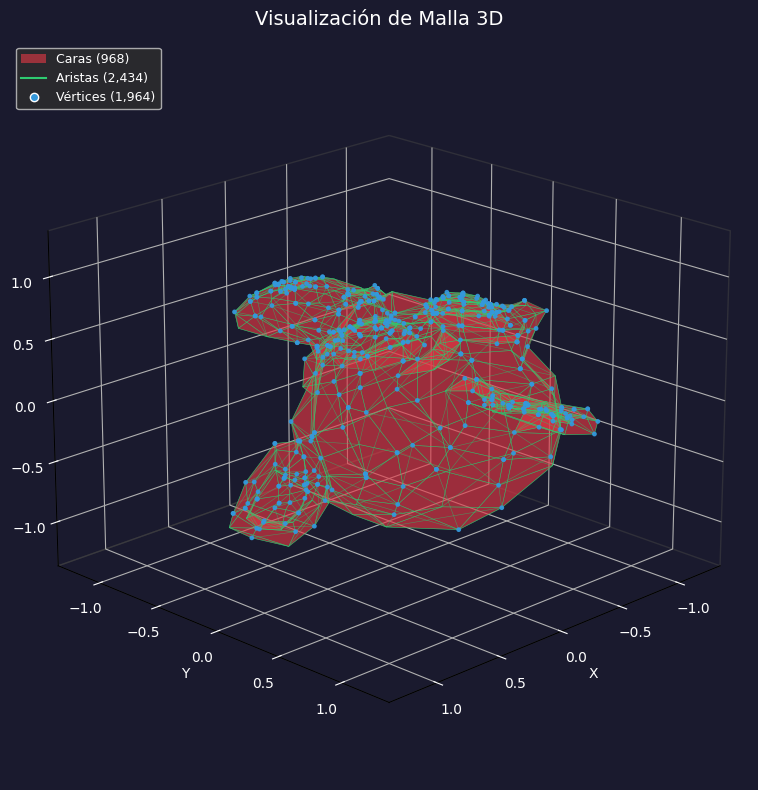

✅ Figura guardada como malla_3d.png


In [18]:
def plot_mesh_components(mesh, elev=20, azim=45, show_vertices=True,
                         show_edges=True, show_faces=True, alpha_faces=0.4):
    """
    Visualiza vértices (azul), aristas (verde) y caras (rojo) de la malla.
    """
    verts = mesh.vertices
    facs  = mesh.faces
    edgs  = mesh.edges_unique

    fig = plt.figure(figsize=(10, 8))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('#1a1a2e')
    fig.patch.set_facecolor('#1a1a2e')

    # ── CARAS (Poly3DCollection) ──────────────────────────────
    if show_faces:
        tri_coords = verts[facs]   # (M, 3, 3)
        poly = Poly3DCollection(tri_coords,
                                alpha=alpha_faces,
                                facecolor='#e63946',
                                edgecolor='none')
        ax.add_collection3d(poly)

    # ── ARISTAS ───────────────────────────────────────────────
    if show_edges:
        edge_coords = verts[edgs]  # (E, 2, 3)
        lines = Line3DCollection(edge_coords,
                                 colors='#2ecc71',
                                 linewidths=0.4,
                                 alpha=0.6)
        ax.add_collection3d(lines)

    # ── VÉRTICES ──────────────────────────────────────────────
    if show_vertices:
        # Para mallas grandes, muestreamos para no saturar
        max_v = min(len(verts), 500)
        idx = np.random.choice(len(verts), max_v, replace=False)
        ax.scatter(verts[idx, 0], verts[idx, 1], verts[idx, 2],
                   c='#3498db', s=6, zorder=5, alpha=0.9,
                   label=f'Vértices (muestra {max_v}/{len(verts)})')

    # Ajustar límites
    mn, mx = verts.min(), verts.max()
    ax.set_xlim(mn, mx); ax.set_ylim(mn, mx); ax.set_zlim(mn, mx)
    ax.view_init(elev=elev, azim=azim)

    # Estética
    ax.set_xlabel('X', color='white'); ax.set_ylabel('Y', color='white'); ax.set_zlabel('Z', color='white')
    ax.tick_params(colors='white')
    for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
        pane.fill = False
        pane.set_edgecolor('#444')

    # Leyenda manual
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='#e63946', alpha=0.6, label=f'Caras ({len(facs):,})'),
        Line2D([0], [0], color='#2ecc71', lw=1.5,  label=f'Aristas ({len(edgs):,})'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db',
               markersize=6, label=f'Vértices ({len(verts):,})', lw=0),
    ]
    ax.legend(handles=legend_elements, loc='upper left',
              facecolor='#2d2d2d', labelcolor='white', fontsize=9)

    ax.set_title('Visualización de Malla 3D', color='white', fontsize=14, pad=12)
    plt.tight_layout()
    return fig, ax


fig, ax = plot_mesh_components(mesh)
plt.savefig('malla_3d.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print('✅ Figura guardada como malla_3d.png')